In [1]:
import matplotlib
matplotlib.use('nbagg')
from scipy import ndimage
import numpy as np
import pickle
import fish_track as ft
import fish_3d as f3
import configparser
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.image import NonUniformImage
from importlib import reload
from scipy import optimize
import itertools
from scipy.spatial.distance import cdist
import yaggie

%load_ext autoreload
%autoreload 2

In [11]:
frames = 300
locations = []
for i in range(0, frames):
    pos = np.load(f'result/location_3d_frame_{i:04}.npy')
    locations.append(pos)

linker = yaggie.track.TrackpyEngine(max_movement=20, memory=2)
trajectories = linker.run(locations, time_points = np.arange(frames))
trajectories = [t for t in trajectories if len(t['position']) > 12]

print(len(trajectories))

with open('vanilla_trajectories.pkl', 'wb') as f:
    pickle.dump(trajectories, f)

Frame 299: 17 trajectories present.
116


<IPython.core.display.Javascript object>


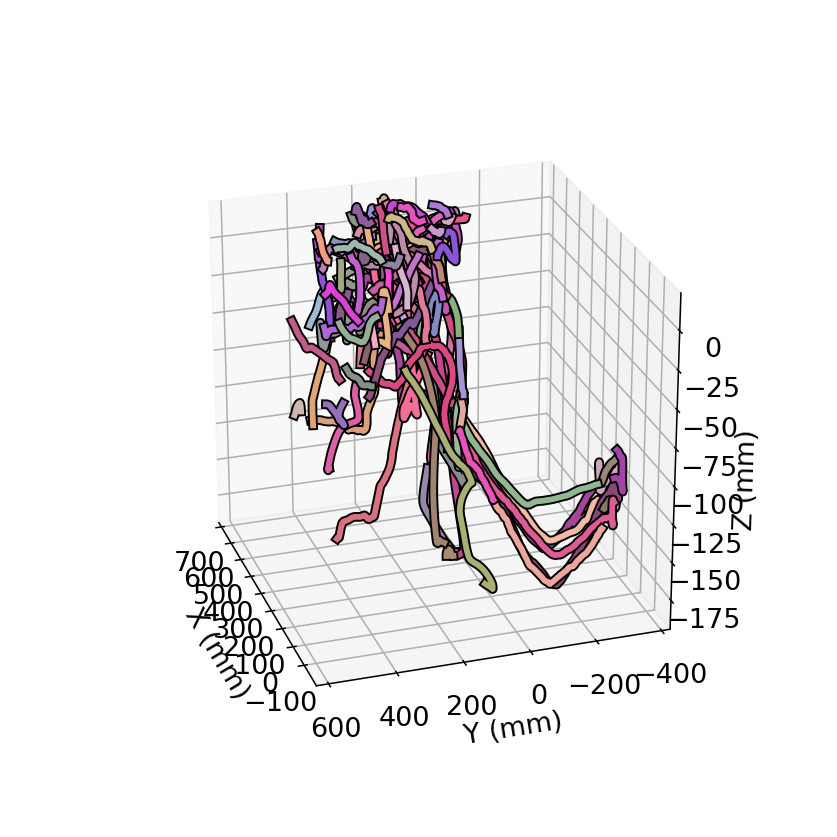

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for t in trajectories:
    signal = np.array(t['position']).T
    signal = ndimage.gaussian_filter1d(signal, 1, axis=1)
    adjust = np.array((1.0, 0.5, 0.8))
    ax.plot(*signal, lw=5, color='k')
    ax.plot(*signal, lw=3, color=np.random.random(3) * (1 - adjust / 16) / 2 +  adjust / 2)
ax.view_init(elev=65, azim=45)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.zaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.xlabel('X (mm)', fontsize=14)
plt.ylabel('Y (mm)', fontsize=14)
ax.set_zlabel('Z (mm)', fontsize=14)
fig.set_size_inches(6, 6)
plt.savefig('traj_3d.pdf')
plt.show()
plt.close()

[  94.95934219  127.76226673 -293.29775081] 2.6112258596500704


<IPython.core.display.Javascript object>


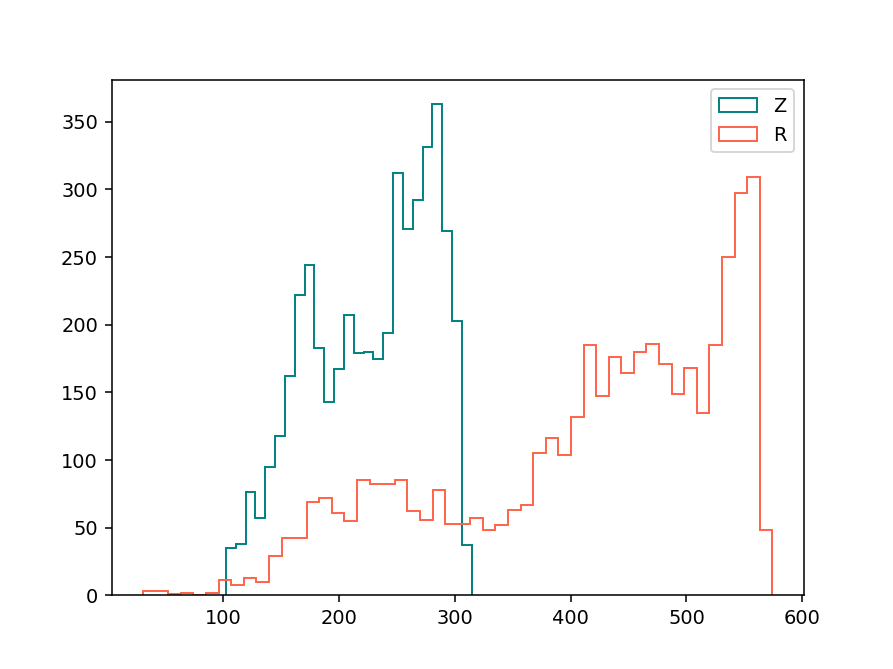

In [13]:
cameras = []
for i in range(1, 4):
    with open(f'result/camera_{i}.pkl', 'rb') as f:
        cameras.append(pickle.load(f))
origins_mv = np.array([[738, 989], [744, 923], [787, 1064]])  # measured manually from FIJI

origin, err = f3.ray_trace.ray_trace_refractive_faster(origins_mv, cameras)
print(origin, err)

frames = 300
locations = np.empty((0, 3))

for t in trajectories:
    pos = t['position']
    locations = np.concatenate([locations, pos])
    
dz = locations[:, -1] - origin[-1]
dr = np.linalg.norm(locations[:, :2] - origin[:2], axis=1)
plt.hist(dz, bins=25, histtype='step', color='teal', label='Z')
plt.hist(dr, bins=50, histtype='step', color='tomato', label='R')
plt.legend()
plt.savefig('spatial_dist.pdf')
plt.show()

<IPython.core.display.Javascript object>


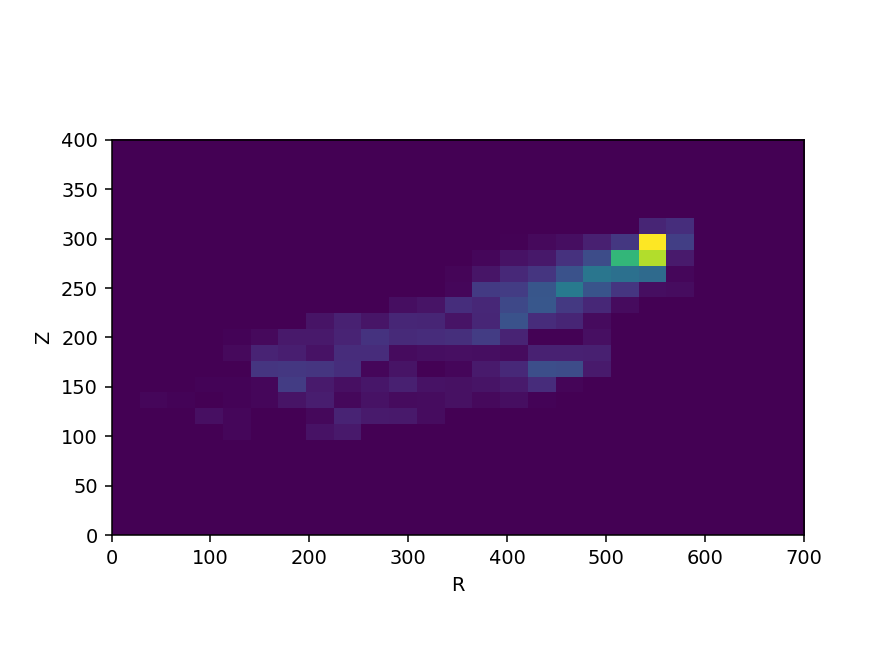

In [14]:
hist_2d, x_edges, y_edges  = np.histogram2d(
    dz, dr, bins=(25, 25), range=((0, 400), (0, 700))
)

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal', ylim=x_edges[[0, -1]], xlim=y_edges[[0, -1]])

x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
im = NonUniformImage(ax, interpolation='nearest')

im.set_data(y_centers, x_centers, hist_2d)
ax.images.append(im)
ax.set_xlabel('R')
ax.set_ylabel('Z')

plt.savefig('spatial_dist_2d.pdf')

plt.show()